<a href="https://colab.research.google.com/github/capofwesh20/Building-a-Leaf-Classification-App/blob/main/Copy_of_(Blank)_Week_1_Project_Building_a_Leaf_Classification_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Building a Leaf Classification App**




# Step 0: Hardware Setup & Software Libraries

We will be utilizing GPUs to train our machine learning model, so we will need to make sure that our Colab notebook is set up correctly. Go to the menu bar and click on Runtime > Change runtime type > Hardware accelerator and **make sure it is set to GPU**. Your Colab notebook may restart once you make the change.

We're going to be using some fantastic open-source Python libraries to load our dataset (`datasets`), train our model (`transformers`), evaluate our model (`evaluate`), and build a demo of our model (`gradio`). So let's go ahead and install all of these libraries. 

In [1]:
%%capture
!pip install datasets transformers evaluate gradio 

# Step 1: Loading a Dataset

In this project, we will be using the `datasets` library, which can load tens of thousands of datasets with a single line of code. It can also be used to apply preprocessing functions. Learn more about the datasets library here: https://huggingface.co/docs/datasets/tutorial

Most datasets are divided into different splits. For example, you'll often see a *training* data subset, which is used to build the model, a *validation* data subset, which is used to measure the performance of the model while it is training, and a *test* dataset which is used to measure the performance of the model at the very end of training, and is usually considered how well the model will perform in the real world (we'll come back to this).

Specifically, we will be using the `beans` dataset that is available for free from the Hugging Face Hub: https://huggingface.co/datasets/beans

In [2]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("beans")

In [3]:
ds_builder.info.description

'Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class.\nDiseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated\nby experts from the National Crops Resources Research Institute (NaCRRI) in\nUganda and collected by the Makerere AI research lab.\n'

In [4]:
ds_builder.info.features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'labels': ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

* **Load the Beans Dataset**

In [5]:
import datasets

from datasets import load_dataset

dataset = load_dataset("beans")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

* **Explore the dataset by running the cells below and answer the questions below**

In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})


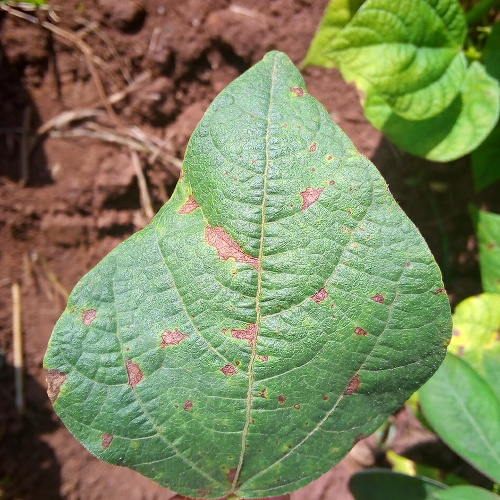

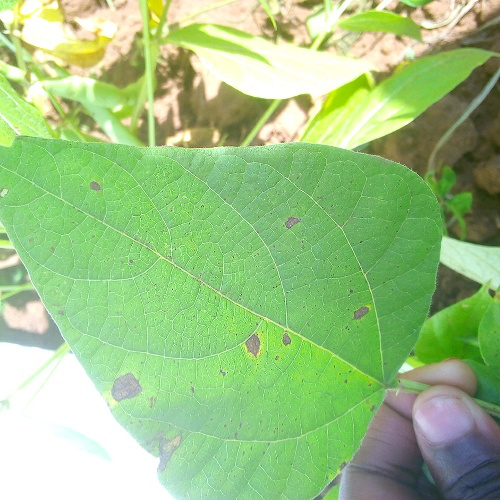

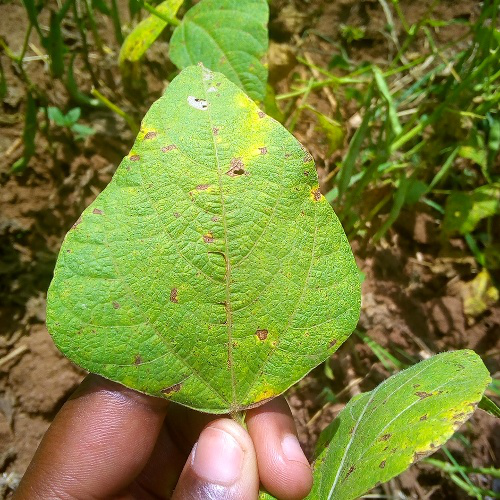

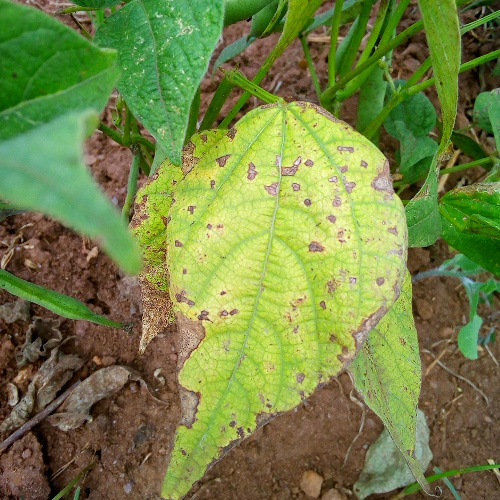

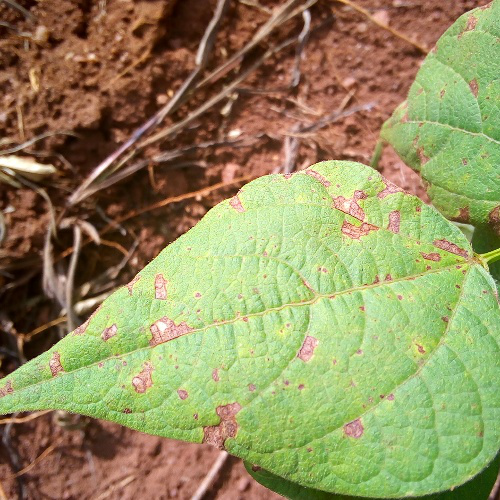

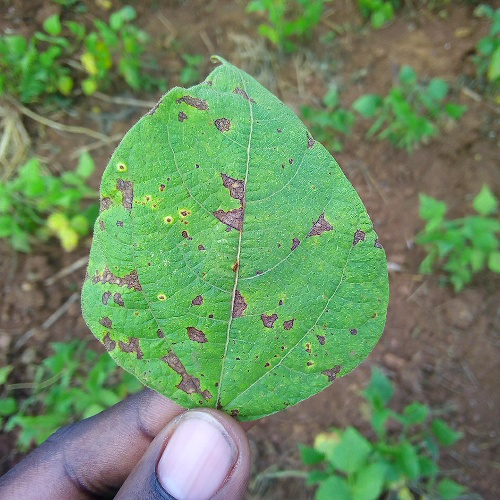

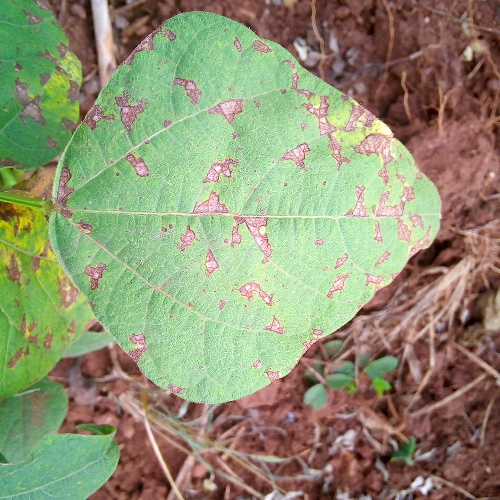

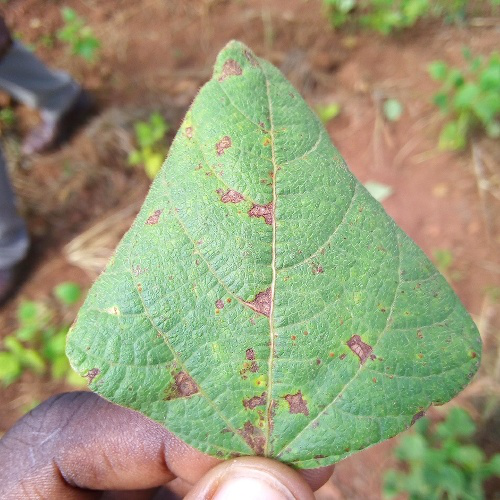

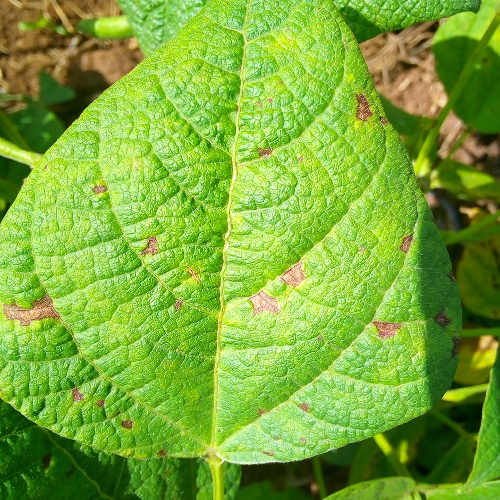

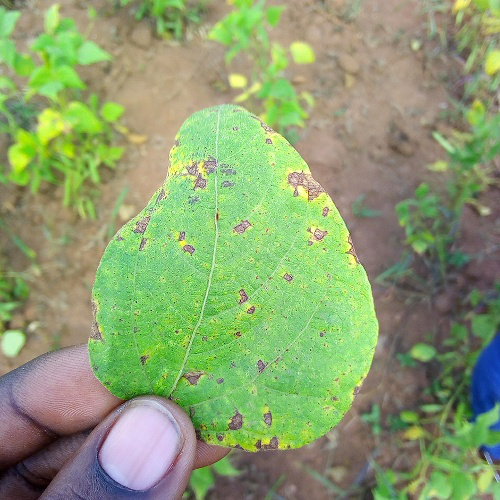

In [7]:
# View the images

for i in range(10):
  display(dataset['train'][i]['image'])

In [8]:
# View the labels

dataset['train'].features['labels']

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

* What information do we have for each sample? we have both image and correct label attached to each.
* How many training samples do we have? Validation samples? Test samples? training data- 1034, Validation - 133, Test - 128
* How many different classes are there in this dataset, and what are the class labels? 3. Angular leaf spot, bean rust and healthy.
* Looking at the first 10 training images, do you notice anything interesting about the images in the dataset? Are they as diverse/representative as you would expect or do they have limitations? I expected the healthy leaf to be without any spot but I may have the wrong notion of a healthy leaf. Apart from that, they all look diverse.

# Step 2: Loading a Pretrained Model

We will be using the `transformers` library, which can load tens of thousands of machine learning models with a few lines of code. It can also be used to fine-tune these models. Learn more about the `transformers` library here: https://huggingface.co/docs/transformers/index

Specifically, we will be using the `Vision Image Transformer` model that is available to anyone from the Hugging Face Hub: https://huggingface.co/google/vit-base-patch16-224. While the details of vision transformers are beyond the scope of this course, we will point out that they are a successor of the widely used convolutional neural network (CNN) architecture and tend to perform better than CNNs at the same tasks (image classificaiton, segmentation, etc.)

Let's start by seeing how the Vision Image Transformer model performs without any further fine-tuning.

* **Load the Vision Image Transformer Model for Inference**

In [ ]:
import transformers
import torch
from transformers import AutoModelForImageClassification

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

model.eval()
model.to(device);

We also need to load the **feature extractor** corresponding to the model, so that we can convert the input images into feature vectors that the model can take as input.

In [10]:

from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

* **Use the Vision Image Transformer Model to Make a Prediction on the Training Images**

The documentation here may be helpful: https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification.forward.example

In [11]:
# First we get the features corresponding to the first training image
encoding = feature_extractor(images=dataset['train'][0]['image'], return_tensors="pt")

# Then pass it through the model and get a prediction

######
encoding.to(device) # move encoding to cuda, if available
with torch.no_grad():
  logits = model(**encoding).logits
######

prediction = logits.argmax(-1).item()

print("Predicted class:", model.config.id2label[prediction])

Predicted class: leaf beetle, chrysomelid


* Try running the model on the first 10 samples in the dataset. 

In [13]:
encodings = feature_extractor(images=dataset['train'][:10]['image'], return_tensors='pt')
encodings.to(device) 
with torch.no_grad():
  logits = model(**encodings).logits
predictions = logits.argmax(-1)
pred_labels = [model.config.id2label[p.item()] for p in predictions]
display(pred_labels)

['leaf beetle, chrysomelid',
 'leaf beetle, chrysomelid',
 'leaf beetle, chrysomelid',
 'bell pepper',
 'leaf beetle, chrysomelid',
 'leaf beetle, chrysomelid',
 'leaf beetle, chrysomelid',
 'leaf beetle, chrysomelid',
 'leaf beetle, chrysomelid',
 'leaf beetle, chrysomelid']

What is the most common prediction? Why do you think that is? 
leaf beetle - because of the multi color, the model is assuming that the rots in some leaves are beetles.


# Step 3: Fine-tuning Your Model on the Dataset

Off the shelf, the Vision Image Transformer will not be usable for the task that we have in mind, since it was trained for "general" image classification, not for the specific categories that we would like to predict. As a result, we will need to "fine-tune" our model.

Learn more about fine-tuning models with the `transformers` library here: https://huggingface.co/docs/transformers/training

We will also need to decide which metric to use for our task. Since our task is a simple image classification task, the `accuracy` metric seems reasonable: https://huggingface.co/spaces/evaluate-metric/accuracy

* **Preprocess the Dataset**

To make things faster, we are going to preprocess the entire dataset so that we convert all of the images to feature vectors. This will allow us to speed up the training as we can pass the feature vectors directly. This code has already been written for you:

In [14]:
import torch

def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = dataset.with_transform(transform)

* **Load the Accuracy Metric**

We now have to decide on a *metric* we will use to measure the performance for our machine learning model. A natural choice for image classification is *accuracy*, which measures the percentage of images that are predicted to have the correct label. 

Read about the `evaluate` library, which contains many common machine learning metrics here: https://github.com/huggingface/evaluate

And use the `evaluate.load()` to load the accuracy metric:

In [15]:
from transformers import AutoModelForImageClassification
import numpy as np
import evaluate

labels = dataset['train'].features['labels'].names

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True 
)

metric = evaluate.load("accuracy")

def compute_metrics(sample):
    return metric.compute(
        predictions=np.argmax(sample.predictions, axis=1), 
        references=sample.label_ids)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* **Fine-Tune the Vision Image Transformer Model on the Entire Training Set**

Now, we will take all of the code that you have written and use it to fine-tune the ViT model on the beans dataset. Simply run the code below, and your model will fine-tune for 4 epochs. On a **GPU**, this should take less than 5 minutes.

In [16]:
from transformers import Trainer
from transformers import TrainingArguments
training_args = TrainingArguments(
  output_dir="./vit-base-beans",  # output directory where the model predictions and checkpoints will be written
  per_device_train_batch_size=16, # batch size
  learning_rate=2e-4,             # learning rate
  num_train_epochs=4,             # number of epochs to train for
  remove_unused_columns=False,    # keep the "image" column
  logging_steps=10,               # how often to print training metrics
  eval_steps=100,                 # how often to measure on the evaluation set
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [17]:
train_results = trainer.train()
trainer.save_model("saved_model_files")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to saved_model_files
Configuration saved in saved_model_files/config.json
Model weights saved in saved_model_files/pytorch_model.bin
Feature extractor saved in saved_model_files/preprocessor_config.json


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1237
  train_runtime            =  0:03:03.33
  train_samples_per_second =       22.56
  train_steps_per_second   =       1.418


# Step 4: Reporting Model Metrics

* **Measure Loss on the Validation Dataset**

In [18]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("validation", metrics)
trainer.save_metrics("validation", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** validation metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.985
  eval_loss               =     0.0555
  eval_runtime            = 0:00:02.65
  eval_samples_per_second =     50.186
  eval_steps_per_second   =      6.415


* What is the loss on the training set and validation sets? 
training loss = 12%
evaluation loss = 5%
* Is there any sign of overfitting? 
No. Since the evaluation loss is lower than the training loss.

* **Measure Accuracy on the Test Dataset**


In [19]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

***** Running Evaluation *****
  Num examples = 128
  Batch size = 8


***** test metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9531
  eval_loss               =     0.1178
  eval_runtime            = 0:00:02.58
  eval_samples_per_second =     49.502
  eval_steps_per_second   =      6.188


* What is your final test accuracy? With the default parameters above, you should expect at test accuracy around 90% or higher? 
test accuracy is 95.31%

# Step 5: Building a Demo

A high-level metric like test accuracy doesn't give us a great idea of how the model will work when presented with new data from the real world. To understand this, we will build a web-based demo that can be used on our phones or computers through a web browser to test our model.

The `gradio` library lets you build web demos of machine learning models with just a few lines of code. Learn more about Gradio here: https://gradio.app/getting_started/

Gradio lets you build machine learning demos simply by specifying (1) a prediction function, (2) the input type and (3) the output type of your model. We have already written most of the prediction code for you. We've reloaded the model and dataset so that the following code runs in a standalone manner, which will be important for Step 6.

In [20]:
import datasets
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

dataset = datasets.load_dataset("beans")

extractor = AutoFeatureExtractor.from_pretrained("saved_model_files")
model = AutoModelForImageClassification.from_pretrained("saved_model_files")

labels = dataset['train'].features['labels'].names

def classify(im):
  features = feature_extractor(im, return_tensors='pt')
  logits = model(features["pixel_values"])[-1]
  probability = torch.nn.functional.softmax(logits, dim=-1)
  probs = probability[0].detach().numpy()
  confidences = {label: float(probs[i]) for i, label in enumerate(labels)} 
  return confidences



  0%|          | 0/3 [00:00<?, ?it/s]

loading configuration file saved_model_files/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

loading configuration file saved_model_files/config.json
Model config ViTConfig {
  "_name_or_path": "saved_model_files",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "angular_leaf_spot",
    "1": "bean_rust",
    "2": "healthy"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "angular_leaf_spot": "0",
    "bean_rust": "1",
    "healthy": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  

* **Build a Gradio web demo of your image classifier and `launch()` it**

Create a `gradio.Interface` and launch it! For image classification, the input component should be `"image"` and output should be a `"label"`. Please also make sure to add a `title`, a `description`, and some image `examples` to make the app easy to use.

Note that we have set `debug=True`, which keeps the following cell running continuously. Press the "stop" icon next to the cell to stop execution so that you can run or re-run other cells.

In [21]:
[['sample_images/angular_lead.png'], 
 ['sample_images/bean_rust.png'], 
 ['sample_images/healthy.png']]

[['sample_images/angular_lead.png'],
 ['sample_images/bean_rust.png'],
 ['sample_images/healthy.png']]

In [22]:
import gradio as gr

sample_images=[['https://s3.amazonaws.com/moonup/production/uploads/1663933284359-611f9702593efbee33a4f7c9.png'],
['https://s3.amazonaws.com/moonup/production/uploads/1663933284374-611f9702593efbee33a4f7c9.png'],
['https://s3.amazonaws.com/moonup/production/uploads/1663933284412-611f9702593efbee33a4f7c9.png']]

title = 'Bean Leaf Classifier'
description = 'This model is trained for beans leaf classification but might give a false result on other leaves'
interface = gr.Interface(fn = classify, inputs = gr.Image(shape=(200, 200)), outputs= 'label',
                         title = title,
                         description = description,
                         examples=sample_images)

interface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://15523.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fedcc77de50>,
 'http://127.0.0.1:7860/',
 'https://15523.gradio.app')

---

### This project is from [Abubakar Abid's](https://twitter.com/abidlabs) course: *Building Computer Vision Applications* on CoRise. Learn more about the course [here](https://corise.com/course/computer-vision).

